In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from collections import defaultdict, Counter
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader as TorchDataLoader

from mplsoccer import Pitch, VerticalPitch, FontManager

sys.path.append("../code")
from data_load import *


## 13-Channel Neural Network Input

Based on the paper's architecture, we create 13 channels for each pass event:

### 6 Sparse Matrices (Player Locations & Velocities)
1. **Attacking teammates location** - Sparse matrix with player positions
2. **Defending teammates location** - Sparse matrix with opponent positions
3. **Attacking teammates velocity component x** - Currently set to 0 (needs tracking data)
4. **Attacking teammates velocity component y** - Currently set to 0 (needs tracking data)
5. **Defending teammates velocity component x** - Currently set to 0 (needs tracking data)
6. **Defending teammates velocity component y** - Currently set to 0 (needs tracking data)

### 5 Dense Matrices (Distances & Angles)
7. **Distance to ball** - Dense matrix with distance from each cell to ball location
8. **Distance to goal** - Dense matrix with distance from each cell to goal location
9. **Sin(angle)** - Sine of angle between location-to-goal and location-to-ball vectors
10. **Cos(angle)** - Cosine of angle between location-to-goal and location-to-ball vectors
11. **Angle to goal (radians)** - Angle in radians from each cell to goal location

### 2 Sparse Matrices (Ball Carrier Velocity Angles)
12. **Sin(angle: ball-velocity vs teammate)** - Sine of angle between ball carrier velocity and direction to each teammate
13. **Cos(angle: ball-velocity vs teammate)** - Cosine of angle between ball carrier velocity and direction to each teammate

**Note on Velocity**: Channels 3-6 (player velocities) are currently set to 0 because we don't have high-frequency tracking data. To compute these properly, you would need to:
- Track player positions across consecutive events
- Compute velocity as (position_t - position_{t-1}) / time_delta
- Or use actual tracking data if available


In [32]:
# Load matches file for Bundesliga 2023/24
matches_file = Path("../data/open-data/data/matches/9/281.json")

with open(matches_file, "r", encoding="utf-8") as f:
    matches = json.load(f)

# Filter for Leverkusen matches
leverkusen_matches = []
for match in matches:
    home_team = match.get("home_team", {}).get("home_team_name", "")
    away_team = match.get("away_team", {}).get("away_team_name", "")
    
    if "Bayer Leverkusen" in home_team or "Bayer Leverkusen" in away_team:
        leverkusen_matches.append({
            "match_id": match["match_id"],
            "match_date": match["match_date"],
            "home_team": home_team,
            "away_team": away_team,
            "home_score": match.get("home_score", 0),
            "away_score": match.get("away_score", 0),
            "is_home": "Bayer Leverkusen" in home_team
        })


In [35]:
matches_with_360 = []
for match in leverkusen_matches:
    match_id = match["match_id"]
    base_paths = [
        Path("../data/open-data/data/three-sixty"),
        Path("data/open-data/data/three-sixty"),
        Path("../data/open-data/data/three-sixty"),
    ]
    
    found = False
    for base_path in base_paths:
        three_sixty_file = base_path / f"{match_id}.json"
        if three_sixty_file.exists():
            matches_with_360.append(match_id)  # Store as integer
            found = True
            break
print(f"Match IDs with 360 (first 10): {matches_with_360[:10]}")


Match IDs with 360 (first 10): [3895302, 3895292, 3895333, 3895340, 3895348, 3895286, 3895220, 3895250, 3895266, 3895275]


In [36]:
# Load a sample match to explore structure
sample_match_id = matches_with_360[0] if matches_with_360 else leverkusen_matches[0]["match_id"]
print(f"Loading sample match: {sample_match_id}")

base_dir_options = [
    "../data/open-data/data",
    "data/open-data/data",
]

event_df, expanded_df, lineup_lookup = None, None, None
for base_dir in base_dir_options:
    test_path = Path(base_dir) / "events" / f"{sample_match_id}.json"
    if test_path.exists():
        print(f"Using base_dir: {base_dir}")
        event_df, expanded_df, lineup_lookup = load_full_match(str(sample_match_id), base_dir=base_dir)
        break

print(f"\nEvent DataFrame shape: {event_df.shape}")
print(f"Expanded DataFrame shape: {expanded_df.shape}")
print(f"\nEvent types:")
print(event_df["type"].value_counts())
print(f"\nLeverkusen lineup (sample):")
for team_name, players in lineup_lookup.items():
    if "Leverkusen" in team_name:
        print(f"\n{team_name}:")
        for i, (pname, meta) in enumerate(list(players.items())[:5]):
            print(f"  {pname}: ID={meta['id']}, Pos={meta['position']}")


Loading sample match: 3895302
Using base_dir: ../data/open-data/data

Event DataFrame shape: (4223, 11)
Expanded DataFrame shape: (56319, 14)

Event types:
type
Pass                 1172
Ball Receipt*        1155
Carry                1022
Pressure              432
Ball Recovery          94
Duel                   52
Block                  36
Goal Keeper            34
Shot                   27
Dribble                26
Clearance              24
Dispossessed           23
Miscontrol             23
Foul Won               17
Interception           17
Foul Committed         17
Dribbled Past          12
Substitution            8
Injury Stoppage         6
50/50                   4
Half End                4
Half Start              4
Referee Ball-Drop       2
Offside                 2
Tactical Shift          2
Bad Behaviour           2
Starting XI             2
Error                   1
Player On               1
Player Off              1
Shield                  1
Name: count, dtype: int64

Leverk

In [39]:
sample_event_id = expanded_df[expanded_df["actor"] == True]["event_id"].iloc[10]

In [40]:
teammates, opps = inspect_event(expanded_df, sample_event_id)

=== Event 63a6070e-0c56-4615-8bab-8f6792d5562a ===
Type: Pass | Team: Werder Bremen | Minute: 0:11
Actor: Mitchell Weiser (ID 8576, Pos: Right Wing Back)
Event location: [44.5, 77.5] → End location: [62.2, 65.8]

Teammates visible:
 - [29.278261132608932, 73.46558002950314]
 - [30.270227378737133, 57.238827110894256]
 - [40.876259308689754, 51.233385717814755]
 - [41.534857489283795, 61.9955680926391]
 - [58.87904885129223, 37.71138176378366]

Opponents visible:
 - [31.142577949493727, 75.1408460419956]
 - [36.71423062630386, 56.46660630381557]
 - [45.226530612478356, 63.609435435898625]
 - [46.7773510382888, 42.07057152240122]
 - [48.340346645486775, 77.82681744462285]


In [41]:
teammates['ff_location']

127     [29.278261132608932, 73.46558002950314]
128    [30.270227378737133, 57.238827110894256]
131    [40.876259308689754, 51.233385717814755]
132      [41.534857489283795, 61.9955680926391]
137      [58.87904885129223, 37.71138176378366]
Name: ff_location, dtype: object

In [42]:
# build 104 by 64 np array

pitch_length = 104
pitch_width = 64
layer_1 = np.zeros((pitch_length, pitch_width))
for row in teammates['ff_location']:
    layer_1[round(row[1]), round(row[0])] += 1
layer_1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(104, 64))

In [9]:
def compute_player_velocities(expanded_df, event_id, previous_event_id=None, 
                               max_time_gap=5.0, max_match_distance=15.0):
    """
    Compute player velocities by matching players across consecutive events.
    
    Since freeze frames don't have player IDs, we match players by:
    1. Same team (teammate status)
    2. Proximity (closest player within max_match_distance)
    
    Args:
        expanded_df: Expanded dataframe with freeze frame data
        event_id: Current event ID
        previous_event_id: Previous event ID (if None, will try to find it)
        max_time_gap: Maximum time gap in seconds to consider (default 5.0)
        max_match_distance: Maximum distance to match a player (default 15.0 meters)
    
    Returns:
        velocity_dict: Dictionary mapping (team, teammate_status, idx) -> [vx, vy]
                      where idx is the index in the current freeze frame
    """
    # Get current event data
    current_event = expanded_df[expanded_df["event_id"] == event_id]
    if current_event.empty:
        return {}
    
    actor_row = current_event[current_event["actor"] == True]
    if actor_row.empty:
        return {}
    
    current_actor = actor_row.iloc[0]
    current_time = current_actor["minute"] * 60 + current_actor["second"]
    
    # Find previous event if not provided
    if previous_event_id is None:
        # Get all events before current time, sorted by time
        all_events = expanded_df[expanded_df["actor"] == True].copy()
        all_events["total_seconds"] = all_events["minute"] * 60 + all_events["second"]
        
        previous_events = all_events[
            (all_events["total_seconds"] < current_time) & 
            (all_events["total_seconds"] >= current_time - max_time_gap)
        ].sort_values("total_seconds", ascending=False)
        
        if previous_events.empty:
            return {}
        
        previous_event_id = previous_events.iloc[0]["event_id"]
    
    # Get previous event data
    previous_event = expanded_df[expanded_df["event_id"] == previous_event_id]
    if previous_event.empty:
        return {}
    
    previous_actor = previous_event[previous_event["actor"] == True].iloc[0]
    previous_time = previous_actor["minute"] * 60 + previous_actor["second"]
    
    time_delta = current_time - previous_time
    if time_delta <= 0 or time_delta > max_time_gap:
        return {}
    
    # Build velocity dictionary
    velocity_dict = {}
    
    # Get all players from current event (excluding actor)
    current_players = current_event[current_event["actor"] == False]
    
    # Get all players from previous event (excluding actor)
    previous_players = previous_event[previous_event["actor"] == False]
    
    # Match players by proximity and team
    for curr_idx, curr_row in current_players.iterrows():
        curr_loc = curr_row["ff_location"]
        if not curr_loc or len(curr_loc) < 2:
            continue
        
        curr_team = curr_row["team"]
        curr_teammate = curr_row["teammate"]
        curr_x, curr_y = curr_loc[0], curr_loc[1]
        
        # Find closest matching player in previous event
        best_match = None
        best_distance = float('inf')
        
        for prev_idx, prev_row in previous_players.iterrows():
            # Must be same team status
            if prev_row["teammate"] != curr_teammate:
                continue
            
            prev_loc = prev_row["ff_location"]
            if not prev_loc or len(prev_loc) < 2:
                continue
            
            prev_x, prev_y = prev_loc[0], prev_loc[1]
            distance = np.sqrt((curr_x - prev_x)**2 + (curr_y - prev_y)**2)
            
            if distance < best_distance and distance < max_match_distance:
                best_distance = distance
                best_match = prev_row
        
        # Compute velocity if match found
        if best_match is not None:
            prev_loc = best_match["ff_location"]
            prev_x, prev_y = prev_loc[0], prev_loc[1]
            
            # Velocity = displacement / time
            vx = (curr_x - prev_x) / time_delta
            vy = (curr_y - prev_y) / time_delta
            
            # Store velocity with a key based on current position (for lookup)
            key = (curr_team, curr_teammate, curr_idx)
            velocity_dict[key] = [vx, vy]
    
    return velocity_dict


In [43]:
def create_13_channels(expanded_df, event_id, pitch_length=104, pitch_width=64, 
                       statsbomb_length=120, statsbomb_width=80, velocity_dict=None):
    """
    Create 13-channel representation for a single event.
    
    Channels:
    1-2: Attacking/Defending teammates location (sparse)
    3-4: Attacking teammates velocity components x, y (sparse)
    5-6: Defending teammates velocity components x, y (sparse)
    7: Distance to ball (dense)
    8: Distance to goal (dense)
    9-10: Sine/Cosine of angle between location-to-goal and location-to-ball (dense)
    11: Angle in radians to goal (dense)
    12-13: Sine/Cosine of angle between ball carrier velocity and teammates (sparse)
    
    Args:
        expanded_df: Expanded dataframe with freeze frame data
        event_id: Event ID to process
        pitch_length: Target pitch length in grid cells (default 104)
        pitch_width: Target pitch width in grid cells (default 64)
        statsbomb_length: StatsBomb coordinate system length (default 120)
        statsbomb_width: StatsBomb coordinate system width (default 80)
    
    Returns:
        channels: np.array of shape (13, pitch_length, pitch_width)
    """
    # Get event data
    event_data = expanded_df[expanded_df["event_id"] == event_id]
    if event_data.empty:
        return None
    
    # Get actor (ball carrier)
    actor_row = event_data[event_data["actor"] == True]
    if actor_row.empty:
        return None
    
    actor = actor_row.iloc[0]
    ball_location_raw = actor["event_location"]  # [x, y] in StatsBomb coords
    ball_end_location_raw = actor.get("end_location")  # [x, y] or None
    
    # Scale coordinates from StatsBomb (120x80) to target grid (104x64)
    scale_x = pitch_width / statsbomb_width   # 64/80 = 0.8
    scale_y = pitch_length / statsbomb_length  # 104/120 ≈ 0.867
    
    def scale_coord(x, y):
        """Scale StatsBomb coordinates to grid indices"""
        x_scaled = x * scale_x
        y_scaled = y * scale_y
        x_idx = int(np.clip(round(x_scaled), 0, pitch_width - 1))
        y_idx = int(np.clip(round(y_scaled), 0, pitch_length - 1))
        return x_idx, y_idx, x_scaled, y_scaled
    
    # Scale ball location
    ball_x_idx, ball_y_idx, ball_x_scaled, ball_y_scaled = scale_coord(ball_location_raw[0], ball_location_raw[1])
    ball_location = [ball_x_scaled, ball_y_scaled]  # Scaled coordinates
    
    # Check if ball_end_location_raw is valid (not None, not NaN, and has at least 2 elements)
    if (ball_end_location_raw is not None and 
        not (isinstance(ball_end_location_raw, float) and np.isnan(ball_end_location_raw)) and
        isinstance(ball_end_location_raw, (list, tuple, np.ndarray)) and 
        len(ball_end_location_raw) >= 2):
        _, _, ball_end_x_scaled, ball_end_y_scaled = scale_coord(ball_end_location_raw[0], ball_end_location_raw[1])
        ball_end_location = [ball_end_x_scaled, ball_end_y_scaled]
    else:
        ball_end_location = None
    
    # Goal location (right side, center of goal) - in scaled coordinates
    goal_location = [pitch_width, pitch_length / 2]  # [64, 52]
    
    # Initialize all channels
    channels = np.zeros((13, pitch_length, pitch_width))
    
    # Separate teammates and opponents
    teammates = event_data[(event_data["teammate"] == True) & (event_data["actor"] == False)]
    opponents = event_data[event_data["teammate"] == False]
    
    # Channel 1: Attacking teammates location (sparse)
    for _, row in teammates.iterrows():
        loc = row["ff_location"]
        if loc and len(loc) >= 2:
            x, y = loc[0], loc[1]  # StatsBomb coordinates
            x_idx, y_idx, _, _ = scale_coord(x, y)
            channels[0, y_idx, x_idx] += 1
    
    # Channel 2: Defending teammates location (sparse) - these are opponents
    for _, row in opponents.iterrows():
        loc = row["ff_location"]
        if loc and len(loc) >= 2:
            x, y = loc[0], loc[1]  # StatsBomb coordinates
            x_idx, y_idx, _, _ = scale_coord(x, y)
            channels[1, y_idx, x_idx] += 1
    
    # Compute ball carrier velocity (from event location to end location)
    if ball_end_location and len(ball_end_location) >= 2:
        # Velocity is the difference (we'll normalize by time if available)
        # For now, use the direction vector
        ball_velocity = [
            ball_end_location[0] - ball_location[0],
            ball_end_location[1] - ball_location[1]
        ]
        # Normalize to get direction (magnitude can be scaled later)
        ball_velocity_mag = np.sqrt(ball_velocity[0]**2 + ball_velocity[1]**2)
        if ball_velocity_mag > 0:
            ball_velocity = [ball_velocity[0] / ball_velocity_mag, ball_velocity[1] / ball_velocity_mag]
    else:
        ball_velocity = [0.0, 0.0]
    
    # Channels 3-4: Attacking teammates velocity components (sparse)
    # Use computed velocities if available, otherwise 0
    for idx, row in teammates.iterrows():
        loc = row["ff_location"]
        if loc and len(loc) >= 2:
            x, y = loc[0], loc[1]  # StatsBomb coordinates
            x_idx, y_idx, _, _ = scale_coord(x, y)
            
            # Try to get velocity from velocity_dict
            vx, vy = 0.0, 0.0
            if velocity_dict is not None:
                # Look up velocity using the key (team, teammate_status, idx)
                team = row["team"]
                teammate = row["teammate"]
                key = (team, teammate, idx)
                if key in velocity_dict:
                    vx, vy = velocity_dict[key]
            
            # Scale velocity to match coordinate scaling
            vx_scaled = vx * scale_x
            vy_scaled = vy * scale_y
            
            channels[2, y_idx, x_idx] = vx_scaled  # vx component
            channels[3, y_idx, x_idx] = vy_scaled  # vy component
    
    # Channels 5-6: Defending teammates velocity components (sparse)
    for idx, row in opponents.iterrows():
        loc = row["ff_location"]
        if loc and len(loc) >= 2:
            x, y = loc[0], loc[1]  # StatsBomb coordinates
            x_idx, y_idx, _, _ = scale_coord(x, y)
            
            # Try to get velocity from velocity_dict
            vx, vy = 0.0, 0.0
            if velocity_dict is not None:
                # Look up velocity using the key (team, teammate_status, idx)
                team = row["team"]
                teammate = row["teammate"]
                key = (team, teammate, idx)
                if key in velocity_dict:
                    vx, vy = velocity_dict[key]
            
            # Scale velocity to match coordinate scaling
            vx_scaled = vx * scale_x
            vy_scaled = vy * scale_y
            
            channels[4, y_idx, x_idx] = vx_scaled  # vx component
            channels[5, y_idx, x_idx] = vy_scaled  # vy component
    
    # Channels 7-8: Distance to ball and goal (dense)
    ball_x, ball_y = ball_location[0], ball_location[1]  # Scaled coordinates
    goal_x, goal_y = goal_location[0], goal_location[1]
    
    for y_idx in range(pitch_length):
        for x_idx in range(pitch_width):
            # Grid indices are already in scaled coordinate system
            pitch_x = x_idx
            pitch_y = y_idx
            
            # Distance to ball
            dist_to_ball = np.sqrt((pitch_x - ball_x)**2 + (pitch_y - ball_y)**2)
            channels[6, y_idx, x_idx] = dist_to_ball
            
            # Distance to goal
            dist_to_goal = np.sqrt((pitch_x - goal_x)**2 + (pitch_y - goal_y)**2)
            channels[7, y_idx, x_idx] = dist_to_goal
    
    # Channels 9-11: Angles (dense)
    for y_idx in range(pitch_length):
        for x_idx in range(pitch_width):
            pitch_x = x_idx
            pitch_y = y_idx
            
            # Vector from location to goal
            vec_to_goal = [goal_x - pitch_x, goal_y - pitch_y]
            # Vector from location to ball
            vec_to_ball = [ball_x - pitch_x, ball_y - pitch_y]
            
            # Angle between vec_to_goal and vec_to_ball
            mag_goal = np.sqrt(vec_to_goal[0]**2 + vec_to_goal[1]**2)
            mag_ball = np.sqrt(vec_to_ball[0]**2 + vec_to_ball[1]**2)
            
            if mag_goal > 0 and mag_ball > 0:
                # Normalize vectors
                vec_to_goal_norm = [vec_to_goal[0] / mag_goal, vec_to_goal[1] / mag_goal]
                vec_to_ball_norm = [vec_to_ball[0] / mag_ball, vec_to_ball[1] / mag_ball]
                
                # Dot product for angle
                cos_angle = vec_to_goal_norm[0] * vec_to_ball_norm[0] + vec_to_goal_norm[1] * vec_to_ball_norm[1]
                cos_angle = np.clip(cos_angle, -1, 1)
                sin_angle = np.sqrt(1 - cos_angle**2)
                
                # Determine sign of sin using cross product
                cross = vec_to_goal_norm[0] * vec_to_ball_norm[1] - vec_to_goal_norm[1] * vec_to_ball_norm[0]
                if cross < 0:
                    sin_angle = -sin_angle
                
                channels[8, y_idx, x_idx] = sin_angle
                channels[9, y_idx, x_idx] = cos_angle
            
            # Angle to goal in radians
            if mag_goal > 0:
                angle_to_goal = np.arctan2(goal_y - pitch_y, goal_x - pitch_x)
                channels[10, y_idx, x_idx] = angle_to_goal
    
    # Channels 12-13: Sine/Cosine of angle between ball carrier velocity and teammates (sparse)
    if ball_velocity[0] != 0 or ball_velocity[1] != 0:
        ball_vel_mag = np.sqrt(ball_velocity[0]**2 + ball_velocity[1]**2)
        if ball_vel_mag > 0:
            ball_vel_norm = [ball_velocity[0] / ball_vel_mag, ball_velocity[1] / ball_vel_mag]
            
            for _, row in teammates.iterrows():
                loc = row["ff_location"]
                if loc and len(loc) >= 2:
                    x, y = loc[0], loc[1]  # StatsBomb coordinates
                    x_idx, y_idx, x_scaled, y_scaled = scale_coord(x, y)
                    
                    # Vector from ball carrier to teammate (in scaled coordinates)
                    vec_to_teammate = [x_scaled - ball_location[0], y_scaled - ball_location[1]]
                    vec_mag = np.sqrt(vec_to_teammate[0]**2 + vec_to_teammate[1]**2)
                    
                    if vec_mag > 0:
                        vec_to_teammate_norm = [vec_to_teammate[0] / vec_mag, vec_to_teammate[1] / vec_mag]
                        
                        # Angle between ball velocity and vector to teammate
                        cos_angle = ball_vel_norm[0] * vec_to_teammate_norm[0] + ball_vel_norm[1] * vec_to_teammate_norm[1]
                        cos_angle = np.clip(cos_angle, -1, 1)
                        sin_angle = np.sqrt(1 - cos_angle**2)
                        
                        # Sign using cross product
                        cross = ball_vel_norm[0] * vec_to_teammate_norm[1] - ball_vel_norm[1] * vec_to_teammate_norm[0]
                        if cross < 0:
                            sin_angle = -sin_angle
                        
                        channels[11, y_idx, x_idx] = sin_angle
                        channels[12, y_idx, x_idx] = cos_angle
    
    return channels


In [11]:
# Example: Create channels WITH velocity computation
# First compute velocities for the sample event
velocities = compute_player_velocities(expanded_df, sample_event_id, max_time_gap=5.0, max_match_distance=15.0)

print(f"Computed velocities for {len(velocities)} players")
if len(velocities) > 0:
    print("Sample velocities:")
    for i, (key, vel) in enumerate(list(velocities.items())[:3]):
        print(f"  {key}: vx={vel[0]:.2f}, vy={vel[1]:.2f}")

# Now create channels with velocity data
channels_with_vel = create_13_channels(
    expanded_df, 
    sample_event_id, 
    pitch_length=104, 
    pitch_width=64,
    velocity_dict=velocities
)

if channels_with_vel is not None:
    print(f"\nChannels with velocity shape: {channels_with_vel.shape}")
    print(f"\nVelocity channel summaries:")
    print(f"  Channel 3 (Attacking vx): Min={channels_with_vel[2].min():.3f}, Max={channels_with_vel[2].max():.3f}, Non-zero={(channels_with_vel[2] != 0).sum()}")
    print(f"  Channel 4 (Attacking vy): Min={channels_with_vel[3].min():.3f}, Max={channels_with_vel[3].max():.3f}, Non-zero={(channels_with_vel[3] != 0).sum()}")
    print(f"  Channel 5 (Defending vx): Min={channels_with_vel[4].min():.3f}, Max={channels_with_vel[4].max():.3f}, Non-zero={(channels_with_vel[4] != 0).sum()}")
    print(f"  Channel 6 (Defending vy): Min={channels_with_vel[5].min():.3f}, Max={channels_with_vel[5].max():.3f}, Non-zero={(channels_with_vel[5] != 0).sum()}")
else:
    print("Failed to create channels with velocity")


Computed velocities for 7 players
Sample velocities:
  ('Werder Bremen', True, 128): vx=-3.33, vy=7.01
  ('Werder Bremen', False, 129): vx=-2.77, vy=9.29
  ('Werder Bremen', False, 130): vx=-2.13, vy=5.99

Channels with velocity shape: (13, 104, 64)

Velocity channel summaries:
  Channel 3 (Attacking vx): Min=-4.914, Max=0.000, Non-zero=3
  Channel 4 (Attacking vy): Min=-2.616, Max=6.712, Non-zero=3
  Channel 5 (Defending vx): Min=-2.676, Max=0.000, Non-zero=4
  Channel 6 (Defending vy): Min=0.000, Max=8.051, Non-zero=4


In [12]:
# Test the function with the sample event
channels = create_13_channels(expanded_df, sample_event_id, pitch_length=104, pitch_width=64)

if channels is not None:
    print(f"Channels shape: {channels.shape}")
    print(f"\nChannel summaries:")
    channel_names = [
        "1. Attacking teammates location",
        "2. Defending teammates location",
        "3. Attacking teammates velocity x",
        "4. Attacking teammates velocity y",
        "5. Defending teammates velocity x",
        "6. Defending teammates velocity y",
        "7. Distance to ball",
        "8. Distance to goal",
        "9. Sin(angle: location-to-goal vs location-to-ball)",
        "10. Cos(angle: location-to-goal vs location-to-ball)",
        "11. Angle to goal (radians)",
        "12. Sin(angle: ball-velocity vs teammate-direction)",
        "13. Cos(angle: ball-velocity vs teammate-direction)"
    ]
    
    for i, name in enumerate(channel_names):
        ch = channels[i]
        print(f"  Channel {i+1}: {name}")
        print(f"    Min: {ch.min():.3f}, Max: {ch.max():.3f}, Mean: {ch.mean():.3f}, Non-zero: {(ch != 0).sum()}")
else:
    print("Failed to create channels")


Channels shape: (13, 104, 64)

Channel summaries:
  Channel 1: 1. Attacking teammates location
    Min: 0.000, Max: 1.000, Mean: 0.001, Non-zero: 5
  Channel 2: 2. Defending teammates location
    Min: 0.000, Max: 1.000, Mean: 0.001, Non-zero: 5
  Channel 3: 3. Attacking teammates velocity x
    Min: 0.000, Max: 0.000, Mean: 0.000, Non-zero: 0
  Channel 4: 4. Attacking teammates velocity y
    Min: 0.000, Max: 0.000, Mean: 0.000, Non-zero: 0
  Channel 5: 5. Defending teammates velocity x
    Min: 0.000, Max: 0.000, Mean: 0.000, Non-zero: 0
  Channel 6: 6. Defending teammates velocity y
    Min: 0.000, Max: 0.000, Mean: 0.000, Non-zero: 0
  Channel 7: 7. Distance to ball
    Min: 0.433, Max: 76.018, Mean: 35.116, Non-zero: 6656
  Channel 8: 8. Distance to goal
    Min: 1.000, Max: 82.462, Mean: 44.876, Non-zero: 6656
  Channel 9: 9. Sin(angle: location-to-goal vs location-to-ball)
    Min: -1.000, Max: 1.000, Mean: 0.219, Non-zero: 6656
  Channel 10: 10. Cos(angle: location-to-goal vs l

In [13]:
# FIXED VERSION: Recreate channels WITH velocity computation
# First, let's recreate the batch with velocity computation enabled

# Get pass events again
pass_events = expanded_df[expanded_df["actor"] == True]["event_id"].unique()[:10]
print(f"Processing {len(pass_events)} events with velocity computation...")

# Create channels with velocity computation
channels_list = []
valid_event_ids = []

# Sort events by time
event_times = []
for event_id in pass_events:
    event_data = expanded_df[expanded_df["event_id"] == event_id]
    actor = event_data[event_data["actor"] == True]
    if not actor.empty:
        time = actor.iloc[0]["minute"] * 60 + actor.iloc[0]["second"]
        event_times.append((event_id, time))

if len(event_times) > 0:
    event_times.sort(key=lambda x: x[1])
    sorted_event_ids = [eid for eid, _ in event_times]
    
    for i, event_id in enumerate(sorted_event_ids):
        # Compute velocities
        previous_event_id = None
        if i > 0:
            previous_event_id = sorted_event_ids[i-1]
        
        velocity_dict = compute_player_velocities(
            expanded_df, event_id, previous_event_id,
            max_time_gap=5.0, max_match_distance=15.0
        )
        
        # Create channels with velocity
        channels = create_13_channels(
            expanded_df, event_id, 
            pitch_length=104, pitch_width=64,
            velocity_dict=velocity_dict
        )
        
        if channels is not None:
            channels_list.append(channels)
            valid_event_ids.append(event_id)
            if len(velocity_dict) > 0:
                print(f"  Event {i+1}: {len(velocity_dict)} velocities computed")
            else:
                print(f"  Event {i+1}: No velocities (first event or no match)")

if len(channels_list) > 0:
    channels_batch = np.stack(channels_list, axis=0)
    print(f"\n✓ Successfully created channels for {len(valid_event_ids)} events")
    print(f"  Batch shape: {channels_batch.shape}")
else:
    print("Failed to create channels")
    channels_batch = None
    valid_ids = []


Processing 10 events with velocity computation...
  Event 1: No velocities (first event or no match)
  Event 2: 16 velocities computed
  Event 3: No velocities (first event or no match)
  Event 4: 12 velocities computed
  Event 5: 8 velocities computed
  Event 6: No velocities (first event or no match)
  Event 7: No velocities (first event or no match)
  Event 8: No velocities (first event or no match)
  Event 9: 7 velocities computed
  Event 10: No velocities (first event or no match)

✓ Successfully created channels for 10 events
  Batch shape: (10, 13, 104, 64)


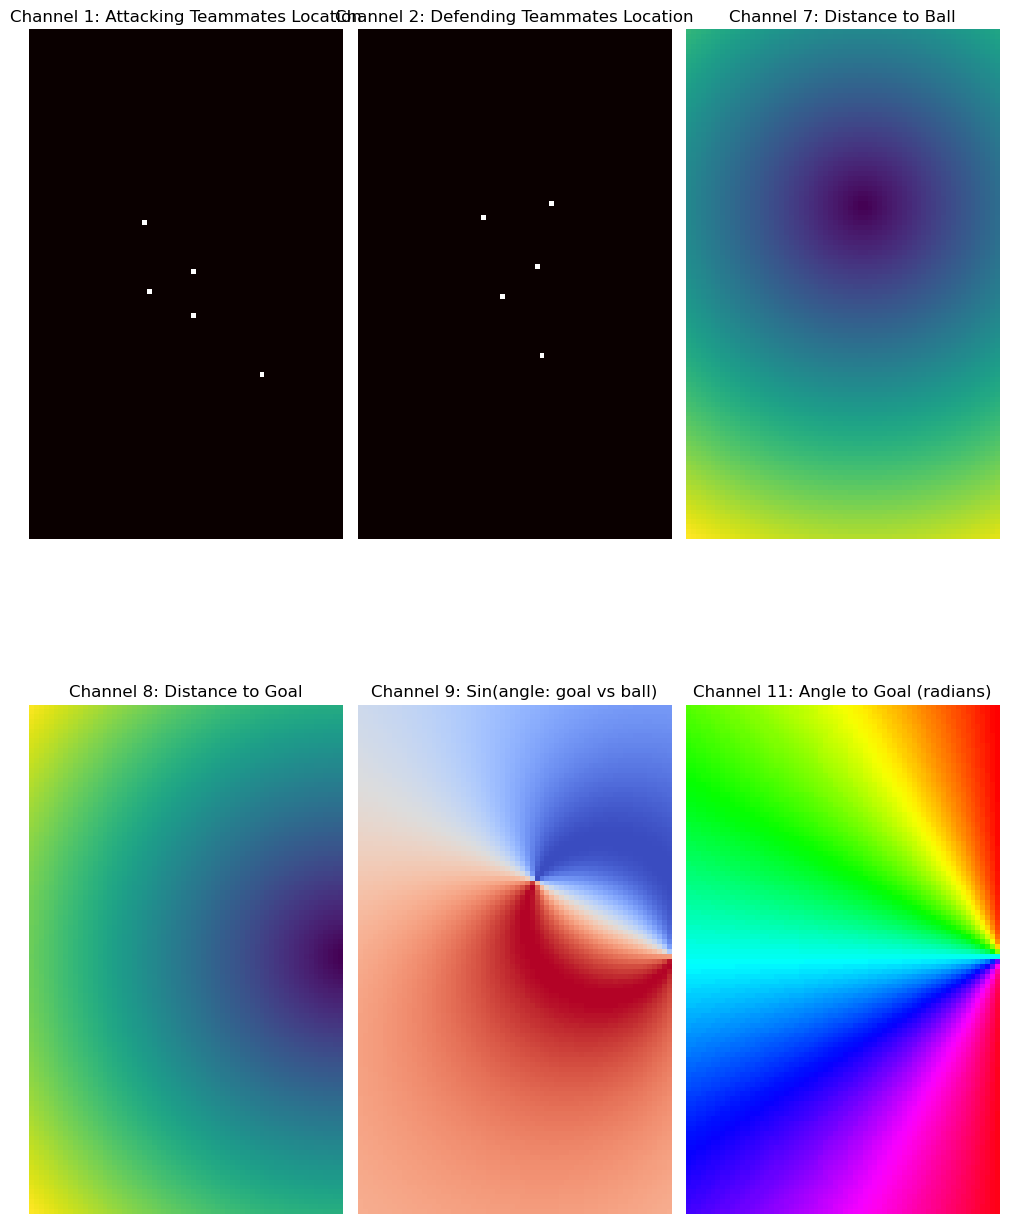

In [14]:
# Visualize a few key channels
if channels is not None:
    fig, axes = plt.subplots(2, 3, figsize=(10, 15))
    axes = axes.flatten()
    
    # Channel 1: Attacking teammates location
    axes[0].imshow(channels[0], origin='lower', cmap='hot', interpolation='nearest')
    axes[0].set_title('Channel 1: Attacking Teammates Location')
    axes[0].axis('off')
    
    # Channel 2: Defending teammates location
    axes[1].imshow(channels[1], origin='lower', cmap='hot', interpolation='nearest')
    axes[1].set_title('Channel 2: Defending Teammates Location')
    axes[1].axis('off')
    
    # Channel 7: Distance to ball
    axes[2].imshow(channels[6], origin='lower', cmap='viridis', interpolation='nearest')
    axes[2].set_title('Channel 7: Distance to Ball')
    axes[2].axis('off')
    
    # Channel 8: Distance to goal
    axes[3].imshow(channels[7], origin='lower', cmap='viridis', interpolation='nearest')
    axes[3].set_title('Channel 8: Distance to Goal')
    axes[3].axis('off')
    
    # Channel 9: Sin(angle)
    axes[4].imshow(channels[8], origin='lower', cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1)
    axes[4].set_title('Channel 9: Sin(angle: goal vs ball)')
    axes[4].axis('off')
    
    # Channel 11: Angle to goal
    axes[5].imshow(channels[10], origin='lower', cmap='hsv', interpolation='nearest')
    axes[5].set_title('Channel 11: Angle to Goal (radians)')
    axes[5].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No channels to visualize")


NameError: name 'valid_ids' is not defined

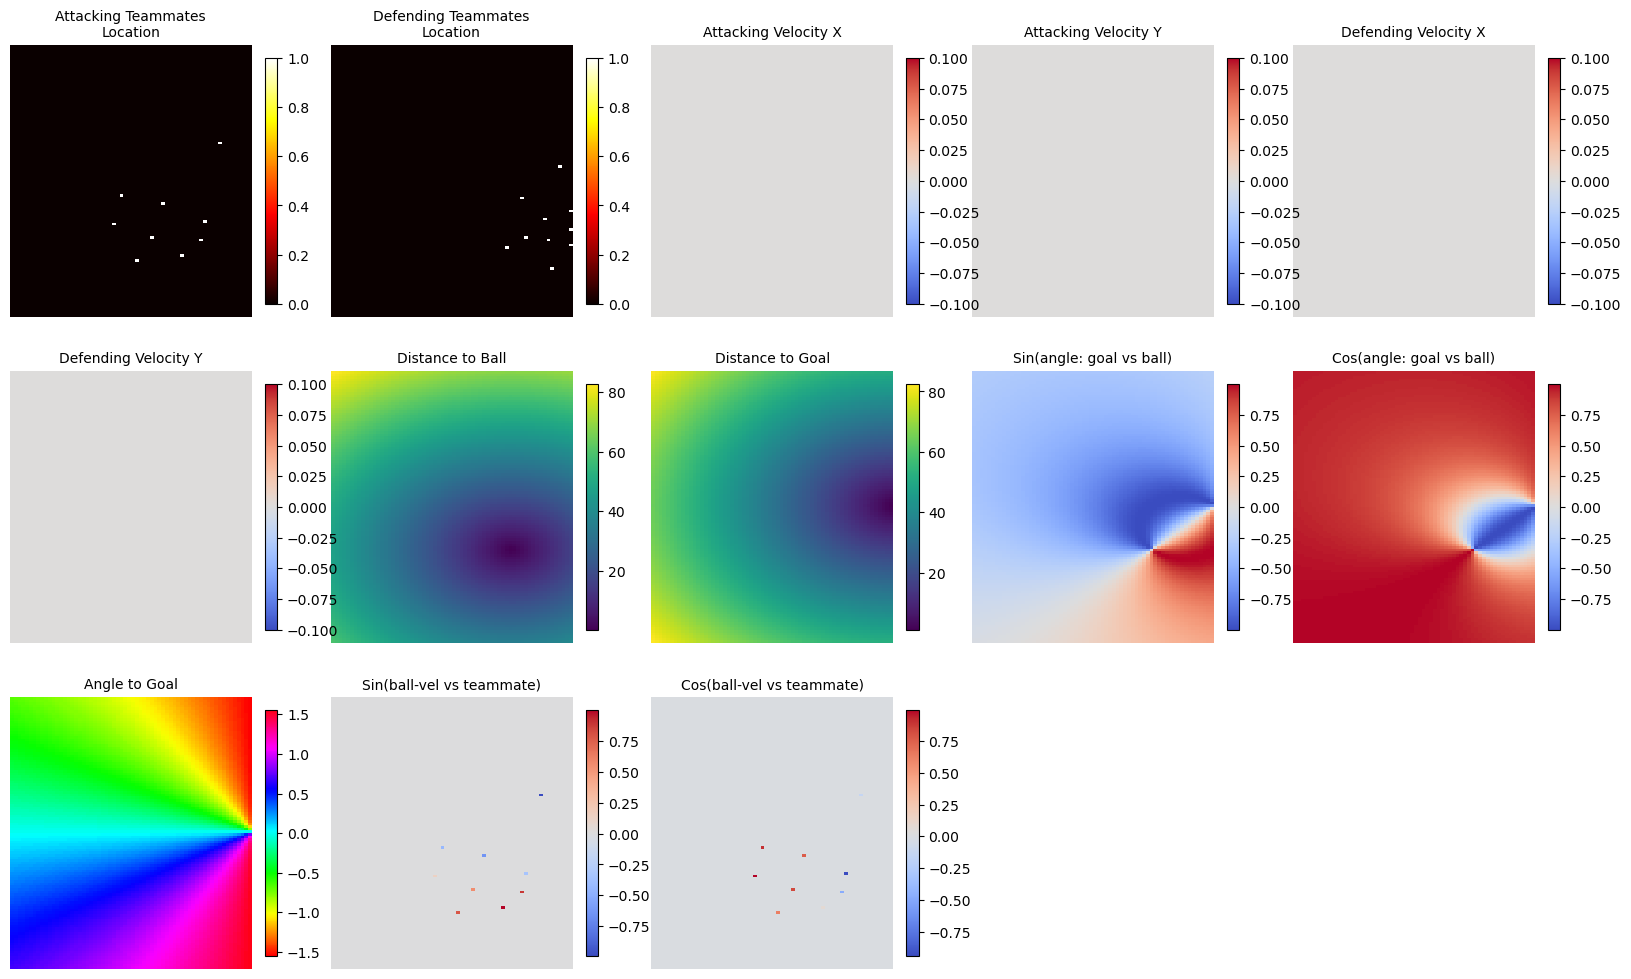

In [15]:
# Visualize channels for the first event
if channels_batch is not None and len(channels_batch) > 0:
    # Select first event
    first_event_channels = channels_batch[0]  # Shape: (13, 104, 64)
    
    # Create a comprehensive visualization
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    axes = axes.flatten()
    
    # Plot key channels
    channels_to_plot = [
        (0, "Attacking Teammates\nLocation", "hot"),
        (1, "Defending Teammates\nLocation", "hot"),
        (2, "Attacking Velocity X", "coolwarm"),
        (3, "Attacking Velocity Y", "coolwarm"),
        (4, "Defending Velocity X", "coolwarm"),
        (5, "Defending Velocity Y", "coolwarm"),
        (6, "Distance to Ball", "viridis"),
        (7, "Distance to Goal", "viridis"),
        (8, "Sin(angle: goal vs ball)", "coolwarm"),
        (9, "Cos(angle: goal vs ball)", "coolwarm"),
        (10, "Angle to Goal", "hsv"),
        (11, "Sin(ball-vel vs teammate)", "coolwarm"),
        (12, "Cos(ball-vel vs teammate)", "coolwarm"),
    ]
    
    for i, (ch_idx, title, cmap) in enumerate(channels_to_plot):
        if i < len(axes):
            im = axes[i].imshow(first_event_channels[ch_idx], 
                                  origin='lower', 
                                  cmap=cmap, 
                                  interpolation='nearest',
                                  aspect='auto')
            axes[i].set_title(title, fontsize=10)
            axes[i].axis('off')
            plt.colorbar(im, ax=axes[i], fraction=0.046)
    
    # Hide unused subplots
    for i in range(len(channels_to_plot), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'13-Channel Representation for Event {valid_ids[0]}', fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualized channels for event: {valid_ids[0]}")
else:
    print("No channels to visualize")


In [18]:
valid_event_ids


['ff56e821-21e9-4cef-ba2a-7eb5eb3769c6',
 'ae74c490-d721-45ca-936f-3975b25d1c94',
 'cf9088bc-7e59-4d57-8ac5-31658da858bb',
 '4464cb75-f45f-4508-8444-2560d1625d06',
 '4f4800c3-368a-457f-8a4e-46c9946e3aae',
 'e9648006-8cd2-43f2-8615-c4cd3f583f05',
 'cfa1f5e1-4e8e-4fc2-bbc8-4df5fdef8283',
 'b88bbf46-30c8-4c60-b8cc-6d855f94f990',
 '696b974a-7b21-415e-9089-0fb05ba1d301',
 'bb0fcac1-b9be-4fac-aca1-bc7bd8d55150']

Channel 8 for event ff56e821-21e9-4cef-ba2a-7eb5eb3769c6
Shape: (104, 64)
Min: 1.000, Max: 82.462
Mean: 44.876, Std: 16.888
Non-zero values: 6656 / 6656

Player locations (y, x coordinates):
  Position (0, 0): value = 82.46211251235322
  Position (0, 1): value = 81.68843247363729
  Position (0, 2): value = 80.91971329657564
  Position (0, 3): value = 80.15609770940699
  Position (0, 4): value = 79.39773296511683
  Position (0, 5): value = 78.64477096412705
  Position (0, 6): value = 77.89736837660179
  Position (0, 7): value = 77.15568676384133
  Position (0, 8): value = 76.4198926981712
  Position (0, 9): value = 75.69015788066504


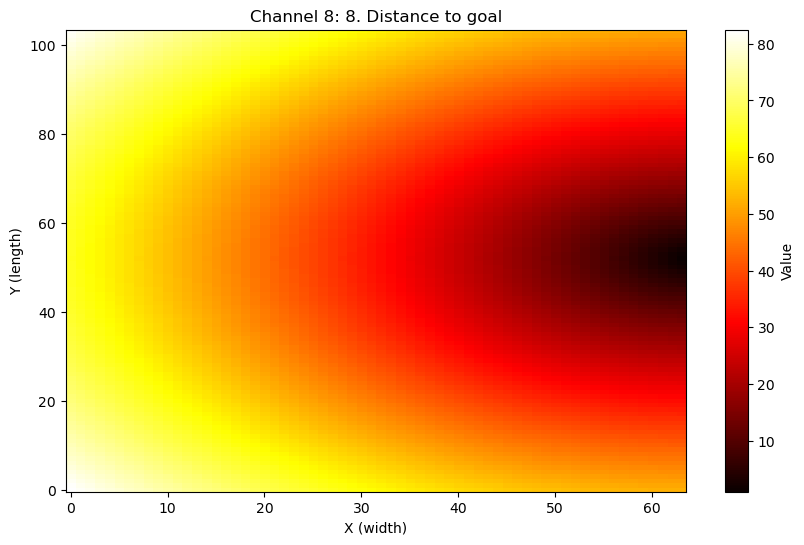

In [20]:

# Inspect a specific channel in detail
if channels_batch is not None and len(channels_batch) > 0:
    channel_idx = 7
    event_idx = 0     # Change this to see different events
    
    selected_channel = channels_batch[event_idx, channel_idx, :, :]
    
    print(f"Channel {channel_idx + 1} for event {valid_event_ids[event_idx]}")
    print(f"Shape: {selected_channel.shape}")
    print(f"Min: {selected_channel.min():.3f}, Max: {selected_channel.max():.3f}")
    print(f"Mean: {selected_channel.mean():.3f}, Std: {selected_channel.std():.3f}")
    print(f"Non-zero values: {(selected_channel != 0).sum()} / {selected_channel.size}")
    
    # Show where players are located
    player_locations = np.where(selected_channel > 0)
    if len(player_locations[0]) > 0:
        print(f"\nPlayer locations (y, x coordinates):")
        for i in range(min(10, len(player_locations[0]))):  # Show first 10
            y, x = player_locations[0][i], player_locations[1][i]
            value = selected_channel[y, x]
            print(f"  Position ({y}, {x}): value = {value}")
    
    # Visualize this specific channel
    plt.figure(figsize=(10, 6))
    plt.imshow(selected_channel, origin='lower', cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Value')
    plt.title(f'Channel {channel_idx + 1}: {channel_names[channel_idx]}')
    plt.xlabel('X (width)')
    plt.ylabel('Y (length)')
    plt.show()
else:
    print("No channels available")


In [29]:
# Quick access: Get channels for a specific event by ID
def get_channels_for_event(channels_batch, valid_event_ids, event_id):
    """Get the 13-channel array for a specific event ID."""
    if event_id in valid_event_ids:
        idx = valid_event_ids.index(event_id)
        return channels_batch[idx]
    else:
        print(f"Event {event_id} not found in valid_ids")
        return None

# Example usage:
if channels_batch is not None and len(valid_event_ids) > 0:
    # Get channels for the first event
    example_event_id = valid_event_ids[0]
    event_channels = get_channels_for_event(channels_batch, valid_event_ids, example_event_id)
    
    if event_channels is not None:
        print(f"Retrieved channels for event: {example_event_id}")
        print(f"Shape: {event_channels.shape}")  # Should be (13, 104, 64)
        print(f"Shape for model input: {event_channels.shape} -> reshape to (1, 13, 104, 64) for batch")


Retrieved channels for event: ff56e821-21e9-4cef-ba2a-7eb5eb3769c6
Shape: (13, 104, 64)
Shape for model input: (13, 104, 64) -> reshape to (1, 13, 104, 64) for batch


## How to Use Velocity Computation

To compute velocities for your channels:

1. **Single event**: Use `compute_player_velocities()` then pass the result to `create_13_channels()`
2. **Batch processing**: The `create_channels_for_events()` function can optionally compute velocities

**Note**: Velocity computation matches players across consecutive events by proximity. This works best when:
- Events are close in time (< 5 seconds)
- Players haven't moved too far (< 15 meters)
- Events are from the same match


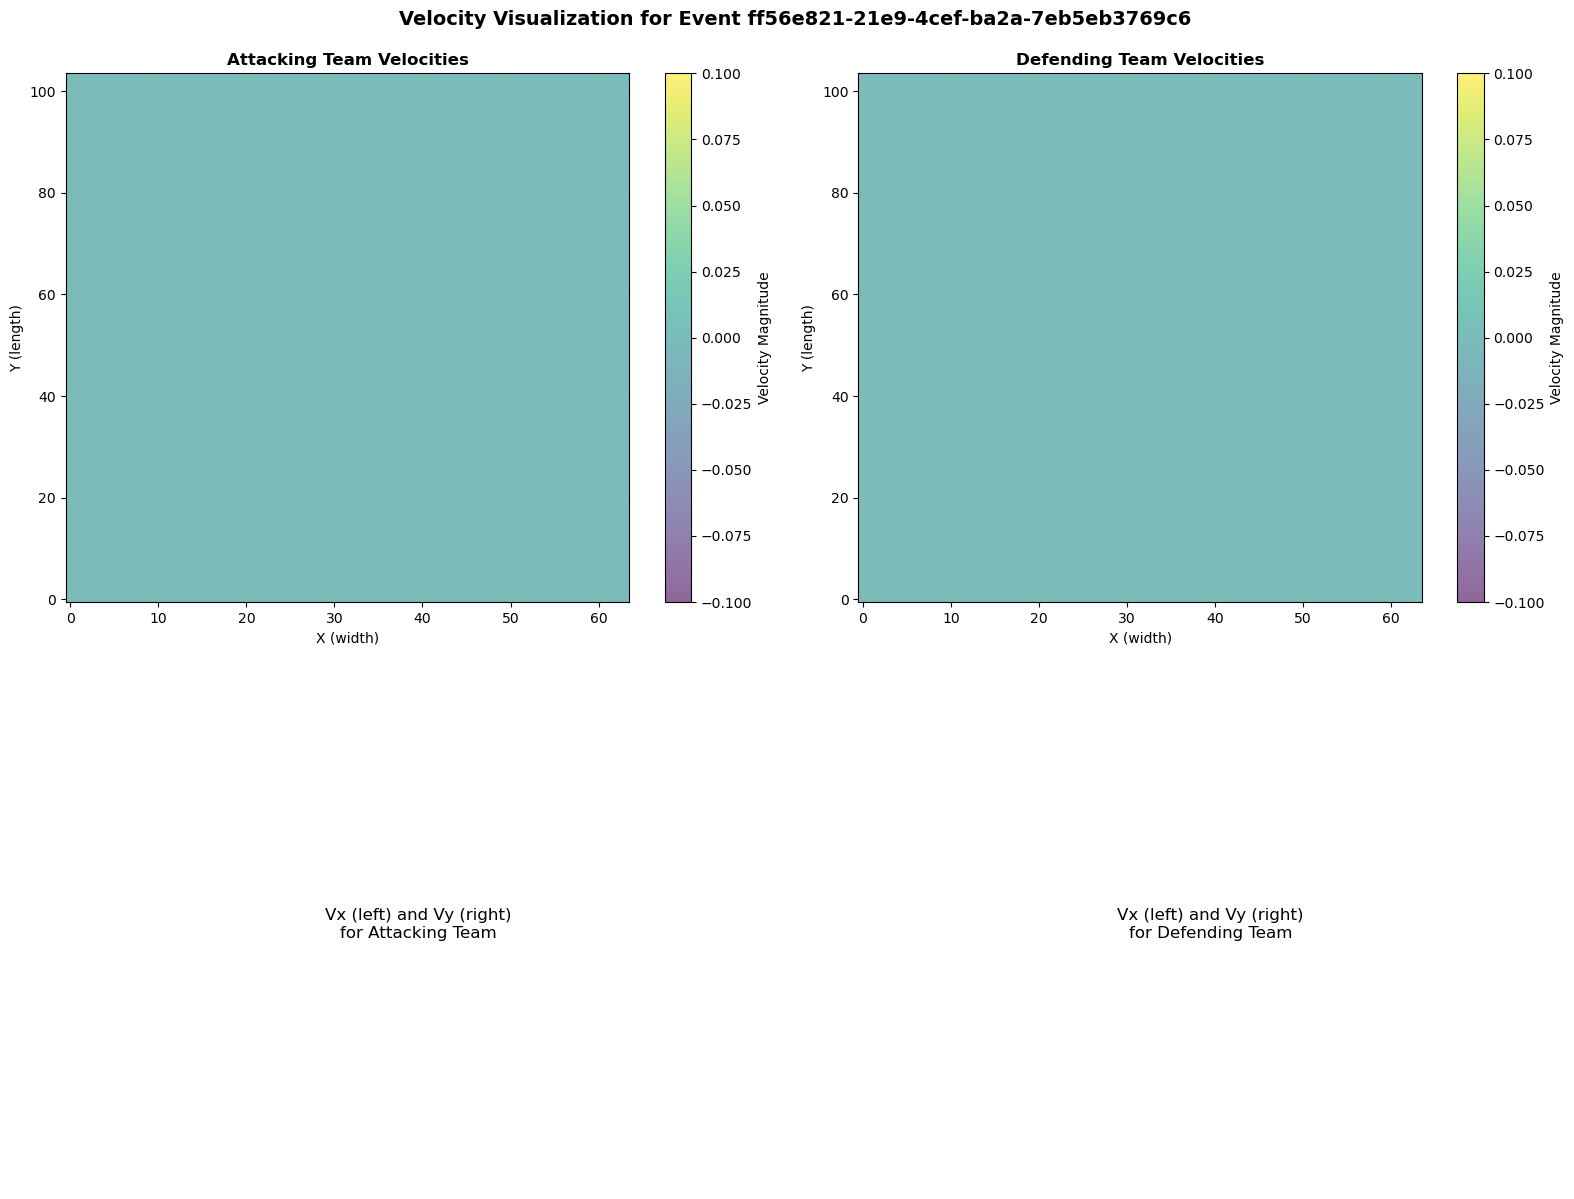

In [ ]:
# Visualize velocity channels with arrows showing direction and magnitude
if channels_batch is not None and len(channels_batch) > 0:
    # Select first event
    first_event_channels = channels_batch[0]  # Shape: (13, 104, 64)
    
    # Create a figure with 4 subplots for velocity channels
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    # Velocity channels: 2-5 (indices 2, 3, 4, 5)
    velocity_channels = [
        (2, 3, "Attacking Team Velocities", "teammates"),
        (4, 5, "Defending Team Velocities", "opponents")
    ]
    
    for plot_idx, (vx_idx, vy_idx, title, team_type) in enumerate(velocity_channels):
        ax = axes[plot_idx]
        
        # Get location channel to know where players are
        if team_type == "teammates":
            loc_channel = first_event_channels[0]  # Attacking teammates location
        else:
            loc_channel = first_event_channels[1]  # Defending teammates location
        
        # Get velocity channels
        vx_channel = first_event_channels[vx_idx]
        vy_channel = first_event_channels[vy_idx]
        
        # Show the velocity magnitude as background
        velocity_magnitude = np.sqrt(vx_channel**2 + vy_channel**2)
        im = ax.imshow(velocity_magnitude, origin='lower', cmap='viridis', 
                       interpolation='nearest', aspect='auto', alpha=0.6)
        plt.colorbar(im, ax=ax, label='Velocity Magnitude')
        
        # Find player positions (where location channel > 0)
        player_positions = np.where(loc_channel > 0)
        
        # Draw velocity vectors as arrows
        if len(player_positions[0]) > 0:
            for i in range(len(player_positions[0])):
                y, x = player_positions[0][i], player_positions[1][i]
                vx = vx_channel[y, x]
                vy = vy_channel[y, x]
                
                # Only draw if velocity is non-zero
                if abs(vx) > 0.01 or abs(vy) > 0.01:
                    # Scale arrow for visibility
                    scale = 3.0
                    ax.arrow(x, y, vx * scale, vy * scale, 
                            head_width=1.5, head_length=1.5, 
                            fc='red', ec='red', linewidth=1.5, alpha=0.8)
                    # Mark player position
                    ax.plot(x, y, 'o', color='white', markersize=4, 
                           markeredgecolor='black', markeredgewidth=0.5)
        
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('X (width)')
        ax.set_ylabel('Y (length)')
        ax.grid(True, alpha=0.3)
    
    # Also show the raw velocity component channels
    for plot_idx in [2, 3]:
        ax = axes[plot_idx]
        if plot_idx == 2:
            # Show Vx and Vy side by side for attacking
            vx = first_event_channels[2]
            vy = first_event_channels[3]
            combined = np.stack([vx, vy], axis=0)
            # Show as two separate images
            ax.text(0.5, 0.5, 'Vx (left) and Vy (right)\nfor Attacking Team', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.axis('off')
        else:
            # Show Vx and Vy side by side for defending
            vx = first_event_channels[4]
            vy = first_event_channels[5]
            combined = np.stack([vx, vy], axis=0)
            ax.text(0.5, 0.5, 'Vx (left) and Vy (right)\nfor Defending Team', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.axis('off')
    
    plt.suptitle(f'Velocity Visualization for Event {valid_ids[0]}', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("No channels to visualize")


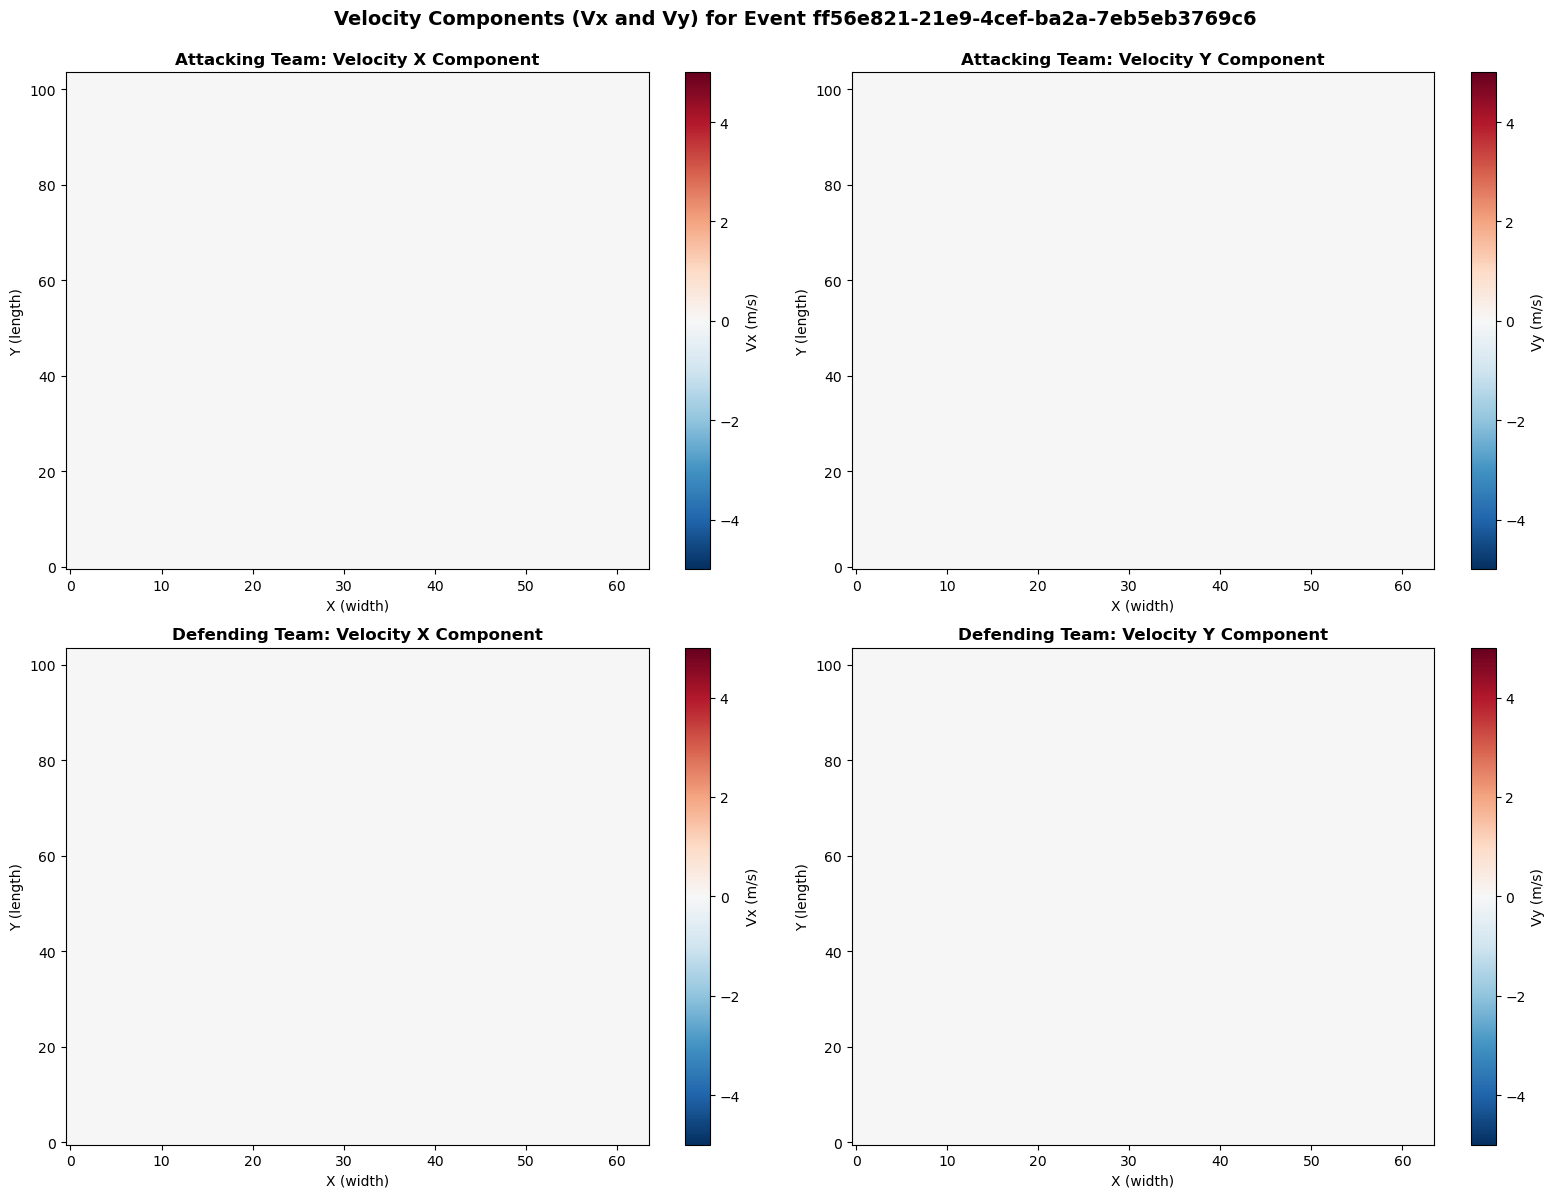

Velocity Statistics:

Attacking Vx: All zeros (no velocity data)

Attacking Vy: All zeros (no velocity data)

Defending Vx: All zeros (no velocity data)

Defending Vy: All zeros (no velocity data)


In [ ]:
# More detailed velocity visualization - show Vx and Vy components separately
if channels_batch is not None and len(channels_batch) > 0:
    first_event_channels = channels_batch[0]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Attacking team velocities
    axes[0, 0].imshow(first_event_channels[2], origin='lower', cmap='RdBu_r', 
                     interpolation='nearest', aspect='auto', vmin=-5, vmax=5)
    axes[0, 0].set_title('Attacking Team: Velocity X Component', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('X (width)')
    axes[0, 0].set_ylabel('Y (length)')
    plt.colorbar(axes[0, 0].images[0], ax=axes[0, 0], label='Vx (m/s)')
    
    axes[0, 1].imshow(first_event_channels[3], origin='lower', cmap='RdBu_r', 
                     interpolation='nearest', aspect='auto', vmin=-5, vmax=5)
    axes[0, 1].set_title('Attacking Team: Velocity Y Component', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('X (width)')
    axes[0, 1].set_ylabel('Y (length)')
    plt.colorbar(axes[0, 1].images[0], ax=axes[0, 1], label='Vy (m/s)')
    
    # Defending team velocities
    axes[1, 0].imshow(first_event_channels[4], origin='lower', cmap='RdBu_r', 
                     interpolation='nearest', aspect='auto', vmin=-5, vmax=5)
    axes[1, 0].set_title('Defending Team: Velocity X Component', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('X (width)')
    axes[1, 0].set_ylabel('Y (length)')
    plt.colorbar(axes[1, 0].images[0], ax=axes[1, 0], label='Vx (m/s)')
    
    axes[1, 1].imshow(first_event_channels[5], origin='lower', cmap='RdBu_r', 
                     interpolation='nearest', aspect='auto', vmin=-5, vmax=5)
    axes[1, 1].set_title('Defending Team: Velocity Y Component', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('X (width)')
    axes[1, 1].set_ylabel('Y (length)')
    plt.colorbar(axes[1, 1].images[0], ax=axes[1, 1], label='Vy (m/s)')
    
    plt.suptitle(f'Velocity Components (Vx and Vy) for Event {valid_ids[0]}', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Print velocity statistics
    print("Velocity Statistics:")
    print("="*60)
    for i, name in [(2, "Attacking Vx"), (3, "Attacking Vy"), 
                    (4, "Defending Vx"), (5, "Defending Vy")]:
        ch = first_event_channels[i]
        non_zero = (ch != 0).sum()
        if non_zero > 0:
            non_zero_values = ch[ch != 0]
            print(f"\n{name}:")
            print(f"  Non-zero values: {non_zero}")
            print(f"  Min: {non_zero_values.min():.3f}, Max: {non_zero_values.max():.3f}")
            print(f"  Mean: {non_zero_values.mean():.3f}, Std: {non_zero_values.std():.3f}")
        else:
            print(f"\n{name}: All zeros (no velocity data)")
else:
    print("No channels to visualize")


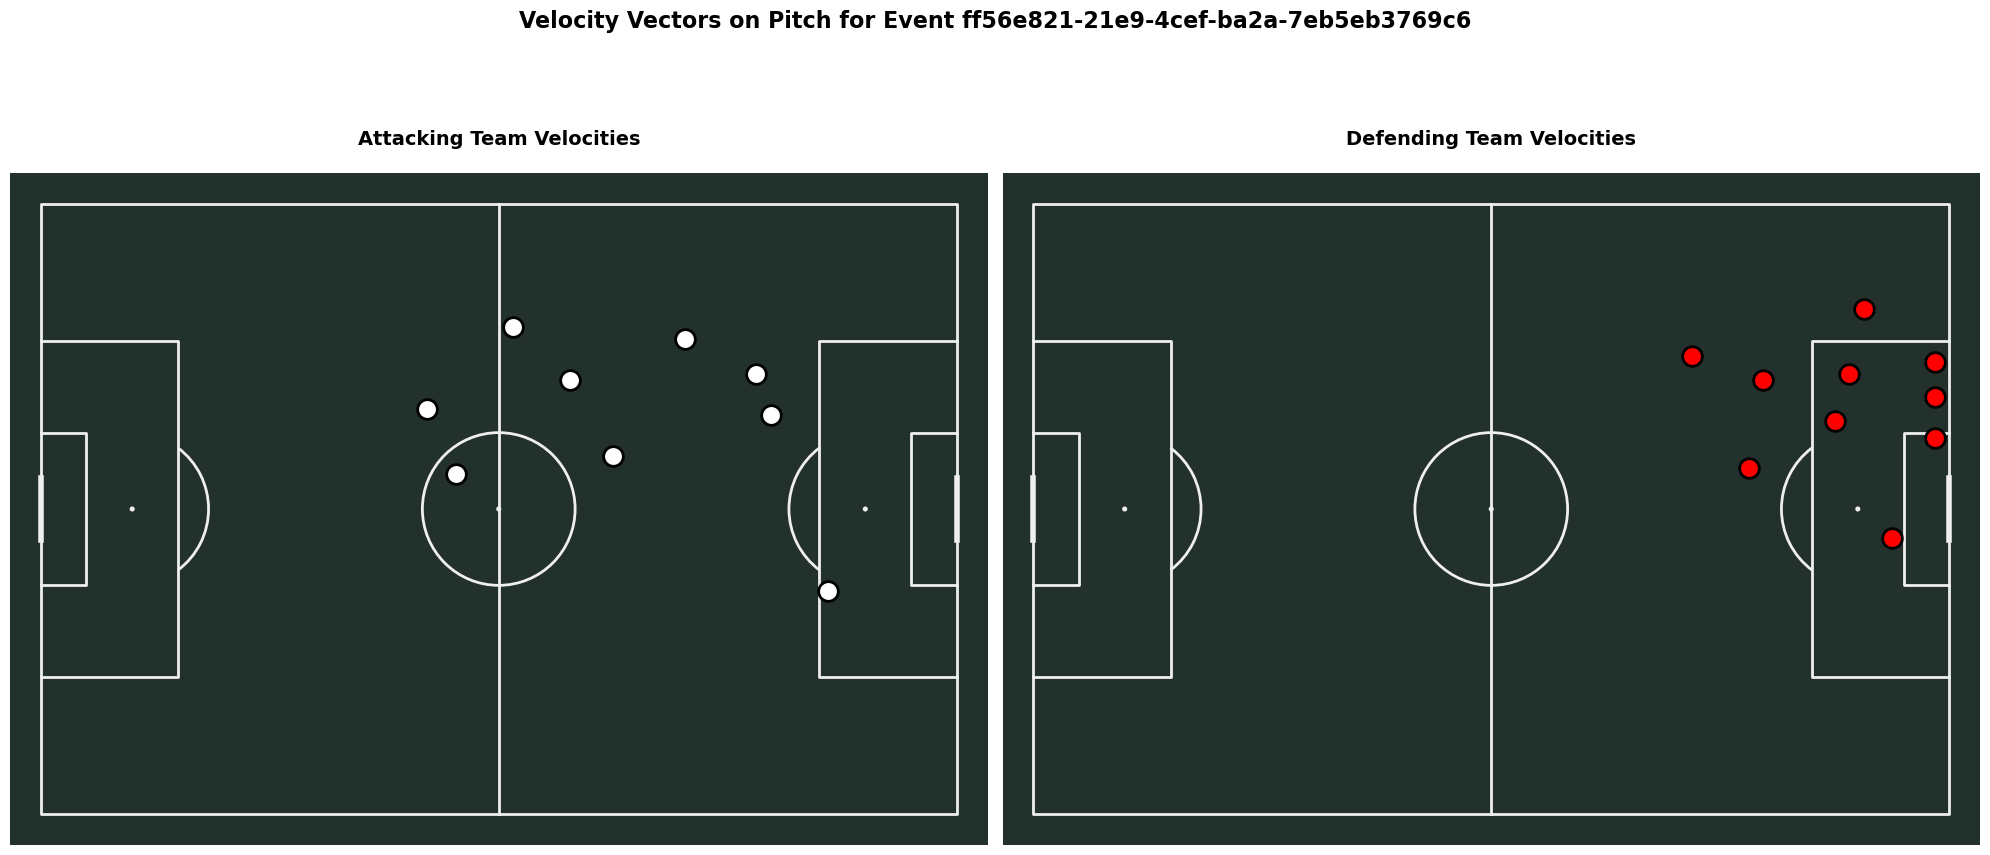

In [ ]:
# Overlay velocity vectors on player locations using mplsoccer pitch
if channels_batch is not None and len(channels_batch) > 0:
    first_event_channels = channels_batch[0]
    
    # Create pitch
    pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    for plot_idx, (team_type, title) in enumerate([("attacking", "Attacking Team Velocities"), 
                                                     ("defending", "Defending Team Velocities")]):
        ax = axes[plot_idx]
        pitch.draw(ax=ax)
        
        # Get appropriate channels
        if team_type == "attacking":
            loc_channel = first_event_channels[0]
            vx_channel = first_event_channels[2]
            vy_channel = first_event_channels[3]
        else:
            loc_channel = first_event_channels[1]
            vx_channel = first_event_channels[4]
            vy_channel = first_event_channels[5]
        
        # Find player positions
        player_positions = np.where(loc_channel > 0)
        
        # Convert grid coordinates to pitch coordinates (StatsBomb: 120x80)
        # Our grid is 104x64, so we need to scale
        scale_to_statsbomb_x = 120 / 64  # width
        scale_to_statsbomb_y = 80 / 104  # length (note: y is length in our grid)
        
        # Draw players and velocities
        for i in range(len(player_positions[0])):
            y_grid, x_grid = player_positions[0][i], player_positions[1][i]
            
            # Convert to StatsBomb coordinates
            x_pitch = x_grid * scale_to_statsbomb_x
            y_pitch = y_grid * scale_to_statsbomb_y
            
            # Get velocity
            vx = vx_channel[y_grid, x_grid]
            vy = vy_channel[y_grid, x_grid]
            
            # Convert velocity to pitch coordinates (scale back)
            vx_pitch = vx / scale_to_statsbomb_x
            vy_pitch = vy / scale_to_statsbomb_y
            
            # Draw player
            pitch.scatter(x_pitch, y_pitch, ax=ax, s=200, 
                         color='white' if team_type == 'attacking' else 'red',
                         edgecolors='black', linewidth=2, zorder=3)
            
            # Draw velocity vector if non-zero
            if abs(vx_pitch) > 0.1 or abs(vy_pitch) > 0.1:
                # Scale for visibility
                scale = 5.0
                ax.arrow(x_pitch, y_pitch, vx_pitch * scale, vy_pitch * scale,
                        head_width=2, head_length=2, fc='yellow', ec='yellow',
                        linewidth=2, alpha=0.8, zorder=4)
        
        ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    plt.suptitle(f'Velocity Vectors on Pitch for Event {valid_ids[0]}', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
else:
    print("No channels to visualize")


In [ ]:
# Debug: Test velocity computation for a single event
print("Testing velocity computation...")
print("="*60)

# Get first event
test_event_id = pass_events[0] if len(pass_events) > 0 else None

if test_event_id:
    print(f"Testing event: {test_event_id}")
    
    # Get event info
    event_data = expanded_df[expanded_df["event_id"] == test_event_id]
    actor = event_data[event_data["actor"] == True]
    if not actor.empty:
        print(f"Event time: {actor.iloc[0]['minute']}:{actor.iloc[0]['second']}")
        print(f"Event type: {actor.iloc[0]['event_type']}")
    
    # Try to find previous event
    all_events = expanded_df[expanded_df["actor"] == True].copy()
    all_events["total_seconds"] = all_events["minute"] * 60 + all_events["second"]
    current_time = actor.iloc[0]["minute"] * 60 + actor.iloc[0]["second"]
    
    previous_events = all_events[
        (all_events["total_seconds"] < current_time) & 
        (all_events["total_seconds"] >= current_time - 5.0)
    ].sort_values("total_seconds", ascending=False)
    
    print(f"\nPrevious events found: {len(previous_events)}")
    if len(previous_events) > 0:
        prev_event_id = previous_events.iloc[0]["event_id"]
        prev_time = previous_events.iloc[0]["total_seconds"]
        time_diff = current_time - prev_time
        print(f"  Previous event: {prev_event_id}")
        print(f"  Time difference: {time_diff:.2f} seconds")
        
        # Compute velocities
        velocities = compute_player_velocities(
            expanded_df, test_event_id, prev_event_id,
            max_time_gap=5.0, max_match_distance=15.0
        )
        print(f"\nVelocities computed: {len(velocities)} players")
        if len(velocities) > 0:
            print("Sample velocities:")
            for i, (key, vel) in enumerate(list(velocities.items())[:5]):
                print(f"  {key}: vx={vel[0]:.3f}, vy={vel[1]:.3f}")
        else:
            print("  No velocities found - checking why...")
            # Check if there are players in current event
            current_players = event_data[event_data["actor"] == False]
            print(f"  Current event has {len(current_players)} non-actor players")
            # Check if there are players in previous event
            prev_event_data = expanded_df[expanded_df["event_id"] == prev_event_id]
            prev_players = prev_event_data[prev_event_data["actor"] == False]
            print(f"  Previous event has {len(prev_players)} non-actor players")
    else:
        print("  No previous events found within 5 seconds")
else:
    print("No test event available")


In [ ]:
def create_channels_for_events(expanded_df, event_ids, pitch_length=104, pitch_width=64):
    """
    Create 13-channel representations for multiple events.
    
    Args:
        expanded_df: Expanded dataframe with freeze frame data
        event_ids: List of event IDs to process
        pitch_length: Target pitch length in grid cells
        pitch_width: Target pitch width in grid cells
    
    Returns:
        channels_array: np.array of shape (n_events, 13, pitch_length, pitch_width)
        valid_event_ids: List of event IDs that were successfully processed
    """
    channels_list = []
    valid_event_ids = []
    
    for event_id in event_ids:
        channels = create_13_channels(expanded_df, event_id, pitch_length, pitch_width)
        if channels is not None:
            channels_list.append(channels)
            valid_event_ids.append(event_id)
    
    if len(channels_list) == 0:
        return None, []
    
    channels_array = np.stack(channels_list, axis=0)
    return channels_array, valid_event_ids

# Example: Create channels for all pass events from the sample match
pass_events = expanded_df[expanded_df["actor"] == True]["event_id"].unique()[:10]  # First 10 pass events
print(f"Processing {len(pass_events)} events...")

channels_batch, valid_ids = create_channels_for_events(expanded_df, pass_events, pitch_length=104, pitch_width=64)

if channels_batch is not None:
    print(f"Successfully created channels for {len(valid_ids)} events")
    print(f"Batch shape: {channels_batch.shape}")  # Should be (n_events, 13, 104, 64)
else:
    print("Failed to create channels")


Processing 10 events...
Successfully created channels for 10 events
Batch shape: (10, 13, 104, 64)


In [ ]:
print(layer_1[73, 29])

1.0
